## **Tutorial on Muller Brown Potential**
Our objective is to observe transutions between state A and B and calculate the free energy landscape.
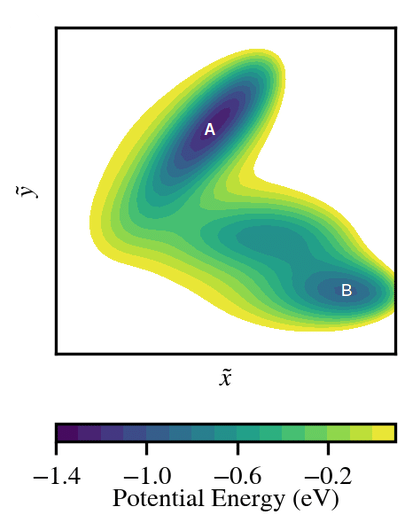

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
!conda install numpy pandas
!conda install -c conda-forge plumed py-plumed

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - numpy
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.6.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    libblas-3.9.0              |22_linux64_openblas          14 KB  conda-forge
    libcblas-3.9.0             |22_linux64_openblas          14 KB  conda-forge
    libgfortran-ng-13.2.0      |       h69a702a_7          24 KB  conda-forge
    libgfortran5-13.2.0        |       hca663fb_7         1.4 MB  conda-forge
  

In [17]:
!rm -rf plumed_pytorch_tutorial
!git clone https://github.com/dhimanray/plumed_pytorch_tutorial.git

Cloning into 'plumed_pytorch_tutorial'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 46 (delta 10), reused 39 (delta 6), pack-reused 0
Receiving objects: 100% (46/46), 452.71 KiB | 10.78 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [35]:
path = 'plumed_pytorch_tutorial/mueller/'

##PES MD input file:
md_input = """
temperature 1.0
tstep 0.005
friction 10.0
dimension 2
nstep 200000
ipos -0.693111 1.40842
periodic false
"""
with open(path+'input', 'w') as file:
  file.write(md_input)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING ##
plumed_input = """
UNITS NATURAL
p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ...
  ARG=p.x,p.y
  PERIODIC=NO
  FUNC=0.15*(-200*exp(-(x-1)^2-10*y^2)-100*exp(-x^2-10*(y-0.5)^2)-170*exp(-6.5*(0.5+x)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(1+x)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2)+146.7)
...
bb: BIASVALUE ARG=ff

xlwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
xuwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0
ylwall: LOWER_WALLS ARG=p.y KAPPA=1000 AT=-0.2
yuwall: UPPER_WALLS ARG=p.y KAPPA=1000 AT=+2.0

newcv: MATHEVAL ARG=p.x,p.y PERIODIC=NO FUNC=x-y

metad: METAD ARG=newcv PACE=100 HEIGHT=1.0 SIGMA=0.1 BIASFACTOR=10 TEMP=1.0

PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=p.x,p.y,metad.*

ENDPLUMED
"""

with open(path+'plumed.dat', 'w') as file:
  file.write(plumed_input)

!cd plumed_pytorch_tutorial/mueller && plumed pesmd < input

Streaming output truncated to the last 5000 lines.
Doing step 100160
Doing step 100180
Doing step 100200
Doing step 100220
Doing step 100240
Doing step 100260
Doing step 100280
Doing step 100300
Doing step 100320
Doing step 100340
Doing step 100360
Doing step 100380
Doing step 100400
Doing step 100420
Doing step 100440
Doing step 100460
Doing step 100480
Doing step 100500
Doing step 100520
Doing step 100540
Doing step 100560
Doing step 100580
Doing step 100600
Doing step 100620
Doing step 100640
Doing step 100660
Doing step 100680
Doing step 100700
Doing step 100720
Doing step 100740
Doing step 100760
Doing step 100780
Doing step 100800
Doing step 100820
Doing step 100840
Doing step 100860
Doing step 100880
Doing step 100900
Doing step 100920
Doing step 100940
Doing step 100960
Doing step 100980
Doing step 101000
Doing step 101020
Doing step 101040
Doing step 101060
Doing step 101080
Doing step 101100
Doing step 101120
Doing step 101140
Doing step 101160
Doing step 101180
Doing step 10

Text(0, 0.5, 'y')

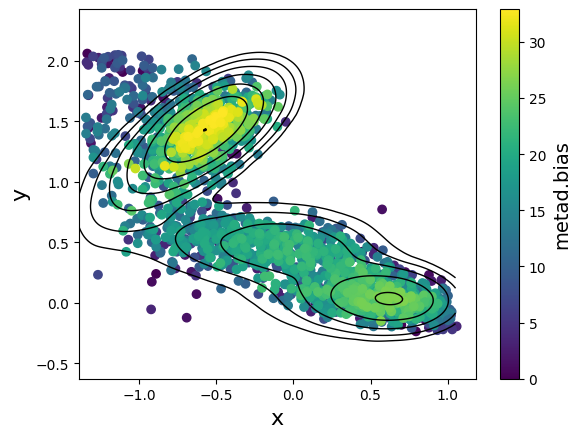

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 200 #number of points for plotting/interpolation

m = 40   #number of contours

x, y, z = np.genfromtxt(r'plumed_pytorch_tutorial/mueller/2d_fes', unpack=True)

for i in range(len(z)):
    if z[i] >= 20.0:
        z[i] = 20
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR')

cp = plt.scatter(l[:,1],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)

plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

Text(0, 0.5, 'x')

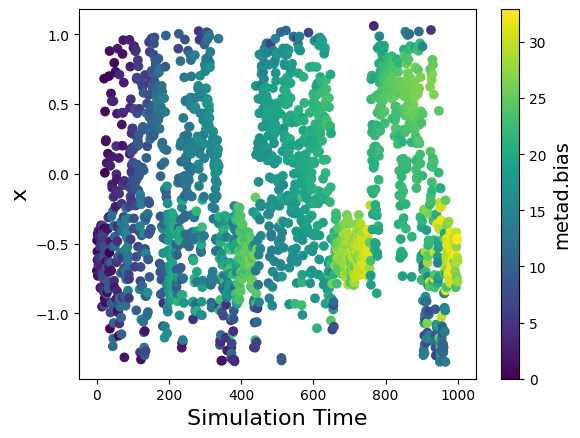

In [37]:
l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR')
cp = plt.scatter(l[:,0],l[:,1],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('x',fontsize=16)

Text(0, 0.5, 'y')

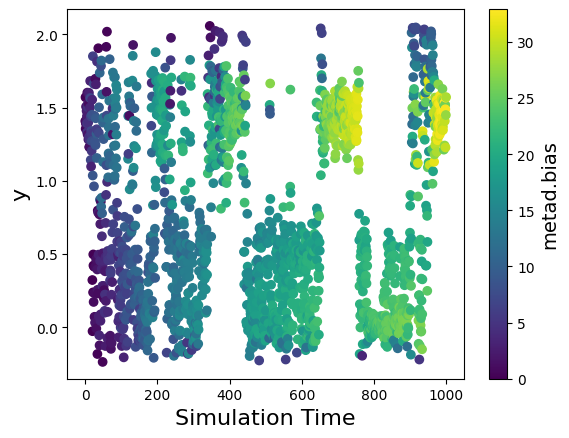

In [38]:
l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR')
cp = plt.scatter(l[:,0],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('y',fontsize=16)

In [39]:
#Calculate 1D Free energy profile along x
!cd plumed_pytorch_tutorial/mueller && python FES_from_Reweighting.py --colvar COLVAR --cv p.x --kt 1.0 --sigma 0.05 -o fes_x_test


 using cv "p.x" found at column 2
 using bias "metad.bias" found at column 4
                              


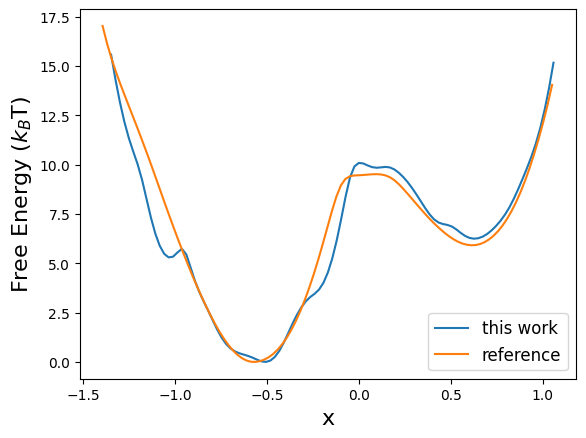

In [40]:
fes_x_test = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_x_test')
fes_x_ref = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_x')

plt.plot(fes_x_test[:,0],fes_x_test[:,1],label='this work')
plt.plot(fes_x_ref[:,0],fes_x_ref[:,1],label='reference')
plt.xlabel('x',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)

In [41]:
#Calculate 1D Free energy profile along y axis
!cd plumed_pytorch_tutorial/mueller && python FES_from_Reweighting.py --colvar COLVAR --cv p.y --kt 1.0 --sigma 0.05 -o fes_y_test


 using cv "p.y" found at column 3
 using bias "metad.bias" found at column 4
                              


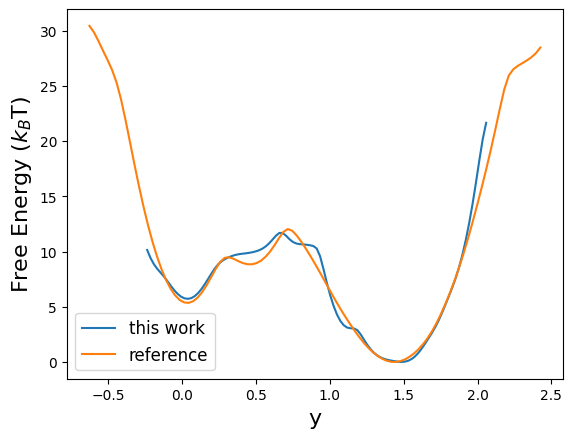

In [42]:
fes_y_test = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_y_test')
fes_y_ref = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_y')

plt.plot(fes_y_test[:,0],fes_y_test[:,1],label='this work')
plt.plot(fes_y_ref[:,0],fes_y_ref[:,1],label='reference')
plt.xlabel('y',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)